                                             MVA - MCMC
                                             TP2 - EM-Algo
                                        Achari Berrada Youssef 

# Exercice 1: Discrete distributions: 

In [256]:
# Import the libraries : 
import numpy as np 
%matplotlib inline 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import multivariate_normal as mn # To evaluate a multivariate normal distribution
from sklearn.cluster import KMeans

In [122]:
def sample_discrete (pmf): 
    # Function to sample from a distribution vector p 
    x = np.random.uniform(0,1)
    i = 1 
    s = pmf[i-1]
    while   s < x  : 
        i = i + 1 
        s = s + pmf[i-1]
    return i ; 

In [123]:
def sample_N (pmf, N ): 
    # Function to sample from a probability mass function pmf N samples
    l = [] 
    for i in range(0,N): 
        l.append(sample_discrete(pmf)) 
    return l; 

In [124]:
def gen_pmf(n) : 
    # Function to generate a propability mass function of length K 
    pmf = np.random.uniform(0,1,n)
    pmf = pmf / pmf.sum()
    return pmf ;

#### Define the parameters : 

In [125]:
n = 40 # size of the dataset 
N = 10000 # Number of iid random values generated 

Generate $\text{pmf} = (p_i)_{1\leq i \leq n} $ the probability mass function of $n$ distincts real numbers $X = \{ x_1,\dots,x_n \}$: 

In [126]:
pmf = gen_pmf(n) # Probability mass function 

Generate $ (X_i)_{1 \leq i \leq n } $ i.i.d. random variables having the distribution of $X$ :

In [127]:
X = sample_N(pmf,N)

In [128]:
bins_hist = np.linspace(1, n+1, n+1,endpoint = True)
bins_bar = np.linspace(1, n, n,endpoint = True)

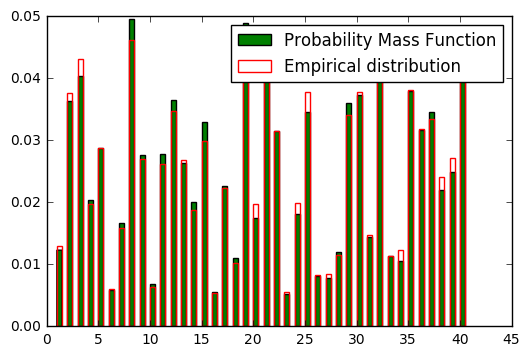

In [129]:
# Comparison of the empirical and true distribution : 
plt.hist(X, normed = 1,bins = bins_hist, facecolor='green',width=0.5); # Empirical distribution 
plt.bar(bins_bar,pmf,edgecolor='r',fc = (0,0,0,0),width=0.5); # True Probability Mass Function
plt.legend({'Probability Mass Function','Empirical distribution'})

# Exercice 2 : Gaussian mixture model and the EM algorithm : 

## Part 1 : 
Generate gaussian mixture according to the Hierarchical model : 
\begin{align} 
 \mathbb{P}_{\theta} (Z_i  = j ) & = \alpha_j  \\
 X_i | \theta , {Z_i = j }  & \sim  \mathcal{N}(\mu_j,\sigma_j^2 ) 
 \end{align}
 

In [252]:
n = 1000 # Size of the data set. 
M = 3 # Number of components of the GMM. 
T = 20 # Number of iteration of the EM step.

Fix the parameters to estimate for $M = 3$ : 

In [242]:
# Priors on the components
alpha = np.array([0.3,0.3,0.4])
# Means of the Gaussians distribution
Mu = np.zeros([M,2])
Mu[0] = np.array([0.2,0.9])
Mu[1] = np.array([0.5,0.1])
Mu[2] = np.array([0.8,0.9])
# Covariance Matrices of the Gaussians distribution 
# Function to generate n semidefinite of size 2
Sigma = np.zeros([M,2,2])
Sigma[0] = np.array([[0.02,0.001],[0.001,0.1]])
Sigma[1] = np.array([[0.05,0.0002],[0.0002,0.01]])
Sigma[2] = np.array([[0.01,0],[0,0.01]])

In [243]:
# Sample n points from the hierarchical model : 
def gmm_sample(n,M,alpha,Mu,Sigma): 
    Z = sample_N(alpha,n)
    X = np.zeros([n,2])
    y = np.zeros(n,dtype=int)
    for i in range(n) : 
        X[i] = np.random.multivariate_normal(Mu[Z[i]-1], Sigma[Z[i]-1]) 
        y[i] = Z[i] 
    return X,y 

### Generate the data points : 

In [244]:
X,y = gmm_sample(n,M,alpha,Mu,Sigma)

In [245]:
COLORS = ['red','green','yellow']
C = [] 
for i in range(n): 
    C.append(COLORS[y[i]-1])

### Plot the data points : 
We plot points generated from a hierarchical model with 3 components : 

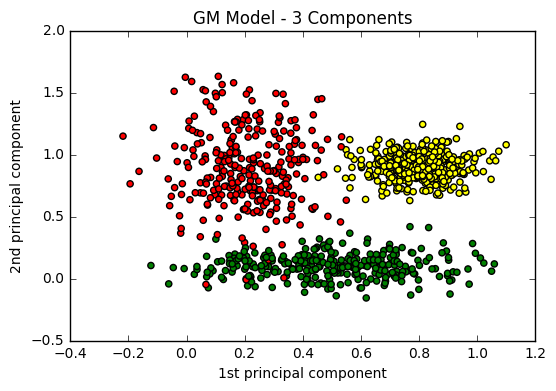

In [246]:
plt.scatter(X[:,0],X[:,1],c=C )
plt.title(u"GM Model - 3 Components") 
plt.xlabel(u"1st principal component")
plt.ylabel(u"2nd principal component")

## Part 2 : 
Expectation-Minimization algorithm to estimate the parameters $\theta = (\alpha_i, \{ \mu_i, \Sigma_i\})_{i = 1..M}$:

In [247]:
def computeQ(X,alpha_em,Mu_em,Sigma_em): 
    # Compute Q of size n*M
    n = X.shape[0] 
    M = Mu_em.shape[0] 
    Q = np.zeros([n,M]) 
    for i in range(M): 
        rvi = mn(mean=Mu_em[i],cov=Sigma_em[i])
        Q[:,i] = rvi.pdf(X)
    Q = np.multiply(Q,alpha_em)
    Q = np.divide(Q.T,np.sum(Q,axis=1)) 
    Q = Q.T
    
    return Q; 

In [248]:
def loglikelihood(X,Q,alpha_em,Mu_em,Sigma_em): 
    # Compute the loglikelihood 
    n = X.shape[0] 
    M = Mu_em.shape[0] 
    L = 0
    I = np.argmax(Q,axis=1) 
    rv = []
    for k in range(M): 
        rv.append(mn(mean=Mu_em[k],cov=Sigma_em[k]))
    for i in range(n): 
        L = L + np.log(rv[I[i]].pdf(X[i]) * alpha_em[I[i]])
    return L 

In [249]:
def EM(X,M,T): 
    # Function to implement the EM algorithm of M component on sample 
    n = X.shape[0] # Size of the Data 
    # Initialization of \theta : 
    # Innitialization with kMeans implemented with Scikit learn : 
    kmeans = KMeans(n_clusters=M, random_state=0).fit(X) ; 
    Mu_em  = kmeans.cluster_centers_
    Sigma_em = np.ones([M,2,2])
    alpha_em = np.zeros(M)
    ## Log likelihood : 
    L=[]
    for k in range(M): 
        Sigma_em[k] = np.cov(X[kmeans.labels_ == k].T)
        alpha_em[k] = np.sum(kmeans.labels_ == k) ; 
    alpha_em = np.divide(alpha_em,n)
    # Set Q as a matrix of probability of size n * M 
    # Iterate from 1 to T the EM Algorithm
    if T == 0 : return alpha_em, Mu_em, Sigma_em
    for t in range(T): 
        #print Sigma_em
        # Expectation step 
        Q = computeQ(X,alpha_em,Mu_em,Sigma_em)
        # Maximization step 
        # Compute the means : 
        for k in range(M) : 
            Mu_em[k] = np.divide(np.dot( X.transpose() , Q[:,k]), np.sum(Q[:,k]) ) 
        # Compute the Covariance matrices : 
        for k in range(M) :
            X_k = X - Mu_em[k] 
            x = np.multiply(X_k.T , Q[:,k] ) 
            Sigma_em[k] = np.divide(np.dot(x ,X_k),np.sum(Q[:,k])) 
        # Compute the priors on the GM Components 
        for k in range(M) : 
            alpha_em[k] = np.sum(Q[:,k]) / np.sum(Q)
        L.append(loglikelihood(X,Q,alpha_em,Mu_em,Sigma_em)) 
    return alpha_em, Mu_em, Sigma_em,L

In [253]:
alpha_em, Mu_em, Sigma_em, L = EM(X,M,T)

### Compute the loglikelihood : 

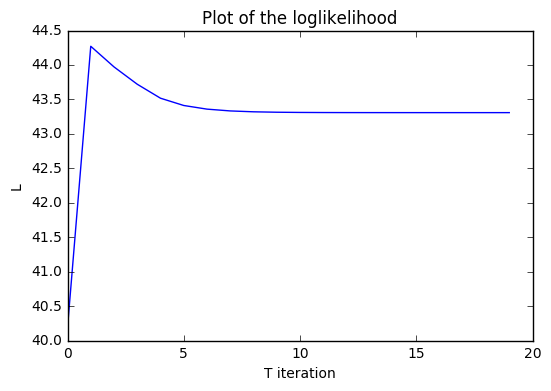

In [254]:
plt.plot(L)
plt.title("Plot of the loglikelihood")
plt.ylabel("L")
plt.xlabel("T iteration")

### Compare the EM parameters obtained : 

In [255]:
alpha 

array([ 0.3,  0.3,  0.4])

In [181]:
alpha_em

array([ 0.30924689,  0.38492314,  0.30582997])

In [182]:
Mu

array([[ 0.2,  0.9],
       [ 0.5,  0.1],
       [ 0.8,  0.9]])

In [183]:
Mu_em

array([[ 0.4776372 ,  0.09040291],
       [ 0.79352094,  0.91101768],
       [ 0.19662513,  0.9068444 ]])

In [184]:
Sigma

array([[[ 0.02,  0.01],
        [ 0.01,  0.1 ]],

       [[ 0.05,  0.02],
        [ 0.02,  0.01]],

       [[ 0.01,  0.  ],
        [ 0.  ,  0.01]]])

In [185]:
Sigma_em

array([[[ 0.05162482,  0.02095016],
        [ 0.02095016,  0.01048711]],

       [[ 0.00979671, -0.00053315],
        [-0.00053315,  0.01016339]],

       [[ 0.01753074,  0.00998589],
        [ 0.00998589,  0.11149271]]])

### Plot contours of the Gaussians finded by the EM : 

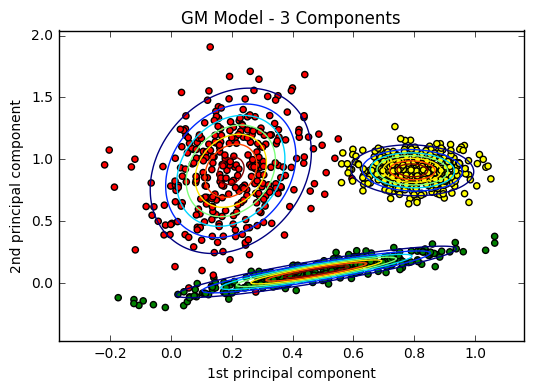

In [186]:
## define the grid :
x, y = np.mgrid[-0.3:1.1:.01, -0.35:1.6:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
for i in range(M): 
    rvi = mn(Mu_em[i], Sigma_em[i])
    plt.contour(x, y, rvi.pdf(pos))

plt.scatter(X[:,0],X[:,1],c=C )
plt.title(u"GM Model - 3 Components") 
plt.xlabel(u"1st principal component")
plt.ylabel(u"2nd principal component")


### Application : 

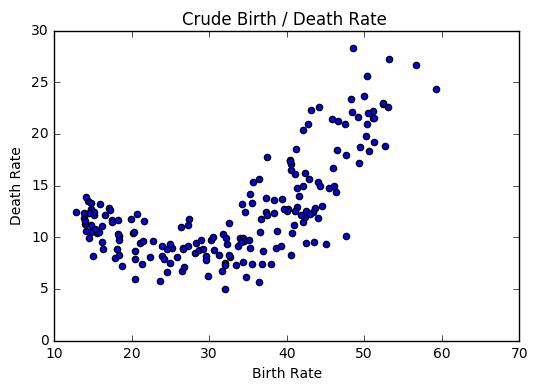

In [201]:
# Load data of the Crude Birth/Death Rate. 
CBDR = pd.read_csv('Crude-BirthDeath-Rate.csv', header=0) 
X_ = CBDR.values
plt.scatter(X_[:,0],X_[:,1])
plt.title(u"Crude Birth / Death Rate ") 
plt.xlabel(u"Birth Rate")
plt.ylabel(u"Death Rate")

The data points are distributed as a Banana shape and therefore it not perfectly adapted for a Gaussian Distribution. 
Let's see what happens : 

In [205]:
## define new adapted grid : 
x_, y_ = np.mgrid[10:60:1, 0:30:1]
pos_ = np.empty(x.shape + (2,))
pos_[:, :, 0] = x; pos_[:, :, 1] = y

### M=1 

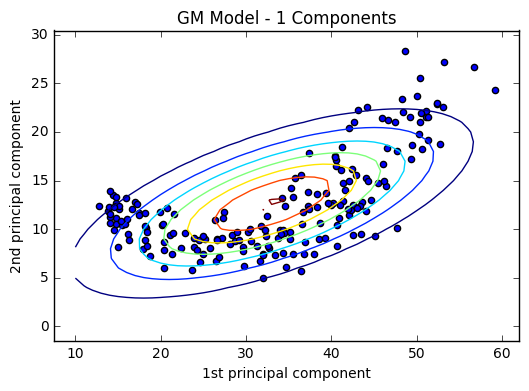

In [207]:
T_ = 50
M_ = 1
a_, Mu_, Si_,_ = EM(X_,M_,T_)
for i in range(M_): 
    rvi = mn(Mu_[i], Si_[i])
    plt.contour(x_, y_, rvi.pdf(pos_))
plt.scatter(X_[:,0],X_[:,1] )
plt.title(u"GM Model - 1 Components") 
plt.xlabel(u"1st principal component")
plt.ylabel(u"2nd principal component")

### M = 2

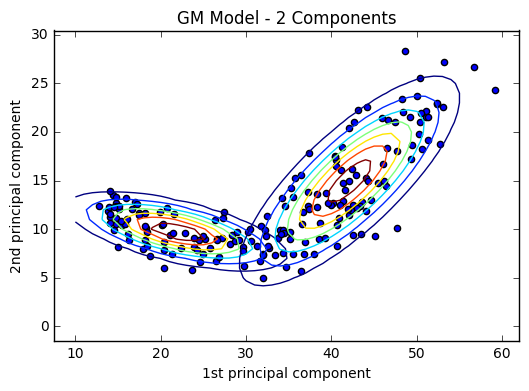

In [208]:
T_ = 50
M_ = 2
a_, Mu_, Si_,_ = EM(X_,M_,T_)
for i in range(M_): 
    rvi = mn(Mu_[i], Si_[i])
    plt.contour(x_, y_, rvi.pdf(pos_))

plt.scatter(X_[:,0],X_[:,1] )
plt.title(u"GM Model - 2 Components") 
plt.xlabel(u"1st principal component")
plt.ylabel(u"2nd principal component")

### M = 3 

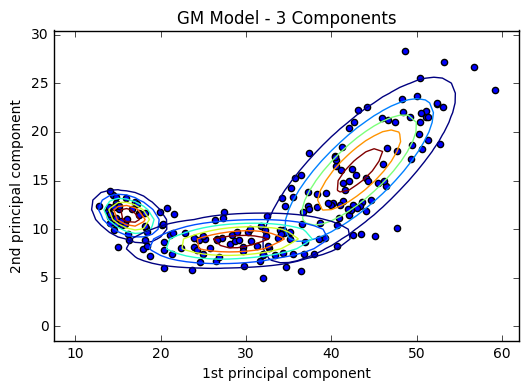

In [211]:
T_ = 50
M_ = 3
a_, Mu_, Si_,L = EM(X_,M_,T_)
for i in range(M_): 
    rvi = mn(Mu_[i], Si_[i])
    plt.contour(x_, y_, rvi.pdf(pos_))

plt.scatter(X_[:,0],X_[:,1] )
plt.title(u"GM Model - 3 Components") 
plt.xlabel(u"1st principal component")
plt.ylabel(u"2nd principal component")

### M =4 

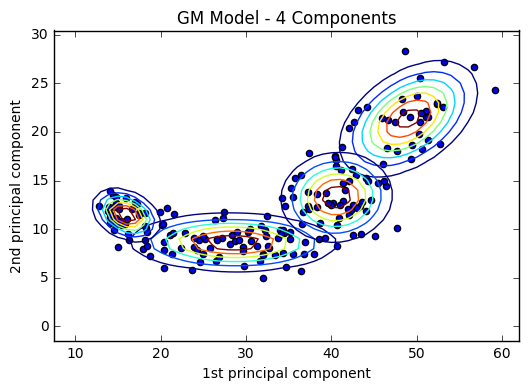

In [215]:
T_ = 50
M_ = 4
a_, Mu_, Si_,_ = EM(X_,M_,T_)
for i in range(M_): 
    rvi = mn(Mu_[i], Si_[i])
    plt.contour(x_, y_, rvi.pdf(pos_))

plt.scatter(X_[:,0],X_[:,1], )
plt.title(u"GM Model - 4 Components") 
plt.xlabel(u"1st principal component")
plt.ylabel(u"2nd principal component")

It seems that the model with 2 and 3 Components are the best adapted for the data. 